## PROJECT 33: Short-term electricity load forecasting

> ### TASK: Stady 1D Convolutional Neural Network for forecasting time series


### Project goals and objectives

#### Project goal

- Studying **1D Convolutional Neural Network for forecasting time series**

#### Project objectives

1. Explore and prepare data 
2. Building 1D CNN model

#### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import re
import math as math

import tensorflow as tf

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Input,  MaxPool1D
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import LSTM


import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA

In [2]:
# Path to data
data_path = "data/continuous dataset.csv"

In [3]:
# Load the data
data_df = pd.read_csv(data_path, parse_dates=['datetime'], index_col=['datetime'])

# Check result 
data_df.head().T

datetime,2015-01-03 01:00:00,2015-01-03 02:00:00,2015-01-03 03:00:00,2015-01-03 04:00:00,2015-01-03 05:00:00
nat_demand,970.345000,912.175500,900.268800,889.953800,893.686500
T2M_toc,25.865259,25.899255,25.937280,25.957544,25.973840
QV2M_toc,0.018576,0.018653,0.018768,0.018890,0.018981
TQL_toc,0.016174,0.016418,0.015480,0.016273,0.017281
W2M_toc,21.850546,22.166944,22.454911,22.110481,21.186089
T2M_san,23.482446,23.399255,23.343530,23.238794,23.075403
QV2M_san,0.017272,0.017265,0.017211,0.017128,0.017059
TQL_san,0.001855,0.001327,0.001428,0.002599,0.001729
W2M_san,10.328949,10.681517,10.874924,10.518620,9.733589
T2M_dav,22.662134,22.578943,22.531030,22.512231,22.481653


#### Description of variables 

- **datetime:** Date-time index corresponding to Panama time-zone UTC-05:00 (index)
- **nat_demand:** National electricity load (Target or Dependent variable)
- **T2M_toc:** Temperature at 2 meters in Tocumen, Panama city
- **QV2M_toc:** Relative humidity at 2 meters in Tocumen, Panama city
- **TQL_toc:** Liquid precipitation in Tocumen, Panama city
- **W2M_toc:** Wind Speed at 2 meters in Tocumen, Panama city
- **T2M_san:** Temperature at 2 meters in Santiago city
- **QV2M_san:** Relative humidity at 2 meters in Santiago city
- **TQL_san:** Liquid precipitation in Santiago city
- **W2M_san:** Wind Speed at 2 meters in Santiago city
- **T2M_dav:** Temperature at 2 meters in David city
- **QV2M_dav:** Relative humidity at 2 meters in David city
- **TQL_dav:** Liquid precipitation in David city
- **W2M_dav:** Wind Speed at 2 meters in David city
- **Holiday_ID:** Unique identification number
- **holiday:** Holiday binary indicator
- **school:** School period binary indicator

#### **For further research and model construction, we will take only the time series of the electrical load.**

In [4]:
# Take a columns
data_df =  data_df[['nat_demand']]

# Check result 
data_df.head()

,nat_demand
datetime,
2015-01-03 01:00:00,970.3450
2015-01-03 02:00:00,912.1755
2015-01-03 03:00:00,900.2688
2015-01-03 04:00:00,889.9538
2015-01-03 05:00:00,893.6865


### EXPLORATORY DATA ANALYSIS 

In [5]:
# Check the missing values
print("Check the number of records")
print("Number of records: ", data_df.shape[0], "\n")

print("Null analysis")
empty_sample = data_df[data_df.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  48048 

Null analysis
Number of records contain 1+ null:  0 



In [6]:
data_df.shape

(48048, 1)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48048 entries, 2015-01-03 01:00:00 to 2020-06-27 00:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nat_demand  48048 non-null  float64
dtypes: float64(1)
memory usage: 750.8 KB


#### Distribution analysis

In [8]:
def distribution(data_for_eda):
    
    fig, ax = plt.subplots(1,3, figsize=(25, 5))
    fig.subplots_adjust(wspace=0.15)
    plt.suptitle("Distribution of observations", fontsize=18)
    
    sns.set_style("whitegrid")
    sns.histplot(data = data_for_eda, bins = 20, stat = 'density', kde = False, ax=ax[0])
    sns.boxenplot(data = data_for_eda, ax=ax[1])
    sns.ecdfplot(data = data_for_eda, ax=ax[2])
    
    fig, ax = plt.subplots(1,1, figsize=(25, 5))
    plt.plot(data_for_eda)
    plt.title("Montly Value", fontsize=18)
    
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

Descriptive statistics:
       nat_demand
count    48048.00
mean      1182.87
std        192.07
min         85.19
25%       1020.06
50%       1168.43
75%       1327.56
max       1754.88
____________________________________________________________________________________________________

Skew:
nat_demand    0.25
dtype: float64
____________________________________________________________________________________________________

Kurtosis:
nat_demand   -0.82
dtype: float64
____________________________________________________________________________________________________



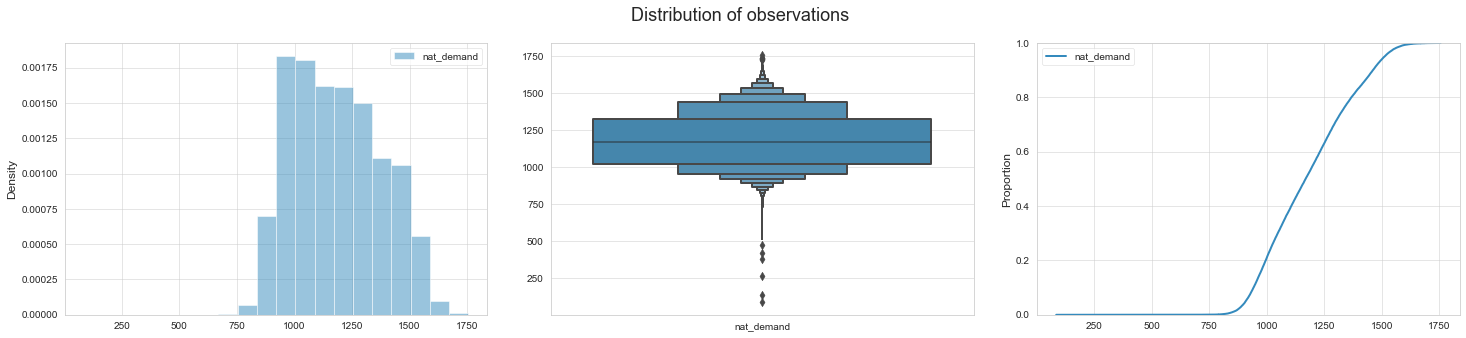

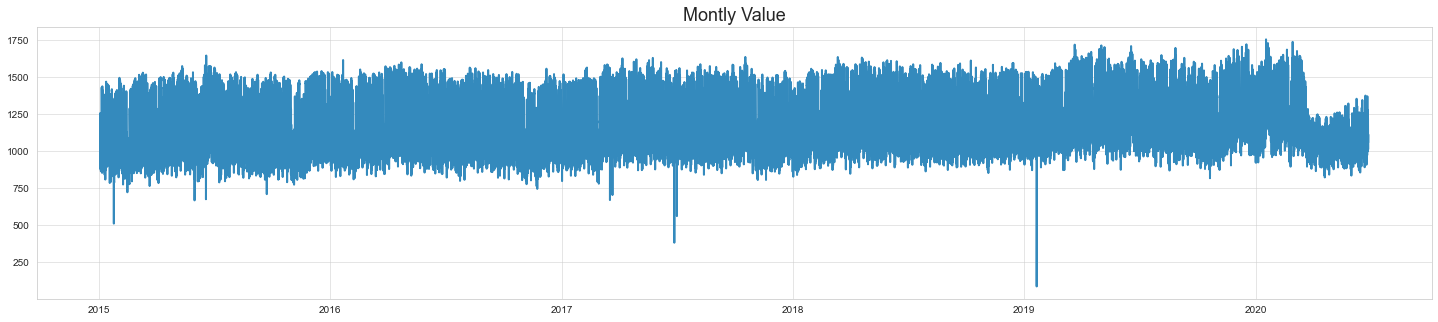

In [9]:
distribution(data_df)

#### Trend analysis

In [10]:
def trend_analysis(data_for_eda):
    # BUILDING MOVING AVERAGES
    
    # 7-day moving average
    data_7d_rol = data_for_eda.rolling(window = 7, center = True).mean()

    # 30-day moving average
    data_30d_rol = data_for_eda.rolling(window = 30, center = True).mean()

    # 365-day moving average
    data_365d_rol = data_for_eda.rolling(window = 365, center = True).mean()
    
    #PLOTTING MOVING AVERAGES
    
    fig, ax = plt.subplots(figsize = (20,5))

    # plotting daily data
    ax.plot(data_for_eda, marker='*', markersize=2, color='0.6',linestyle='None', label='Daily')

    # A fallback version of the presentation
    # ax.plot(novaya_entering_t2, linewidth=2, label='Daily', color='0.6', alpha = 0.5 )

    # plotting 7-day rolling data
    ax.plot(data_7d_rol, linewidth=2, label='7-d Rolling Mean')

    # plotting 30-day rolling data
    ax.plot(data_30d_rol, linewidth=2, label='30-d Rolling Mean')

    # plotting annual rolling data
    ax.plot(data_365d_rol, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean)')

        
    # Beautification of plot
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('People')
    ax.set_title('Trends in series', fontsize=18)

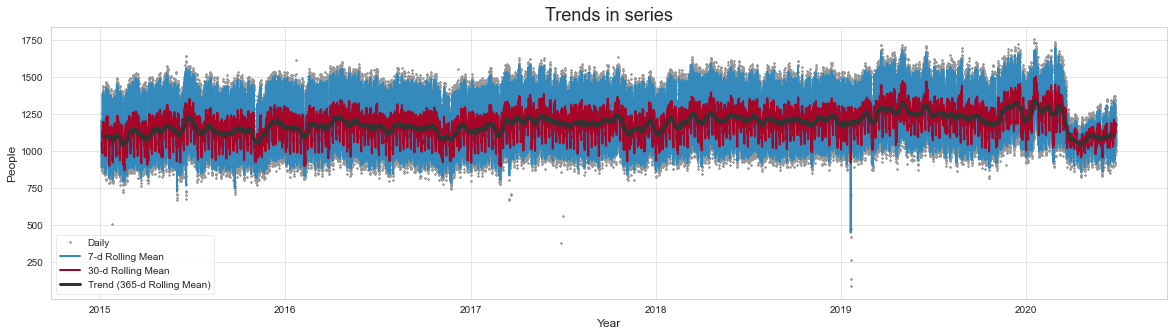

In [11]:
trend_analysis(data_df)

#### Autocorrelation analysis

In [12]:
def autocorr_analysis(data_for_eda):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi= 100)
    plt.suptitle("Autocorrelation analysis", fontsize=18)
    
    sm.graphics.tsa.plot_acf(data_for_eda.values.squeeze(), lags=50, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data_for_eda.values.squeeze(), lags=50, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(19.7, 3), dpi= 100)
    pd.plotting.autocorrelation_plot(data_for_eda, ax=ax)
    plt.show()

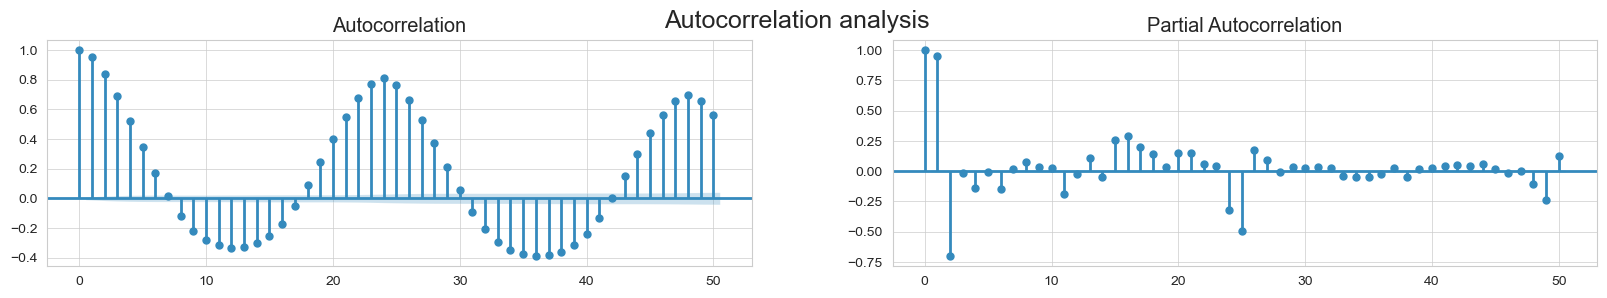

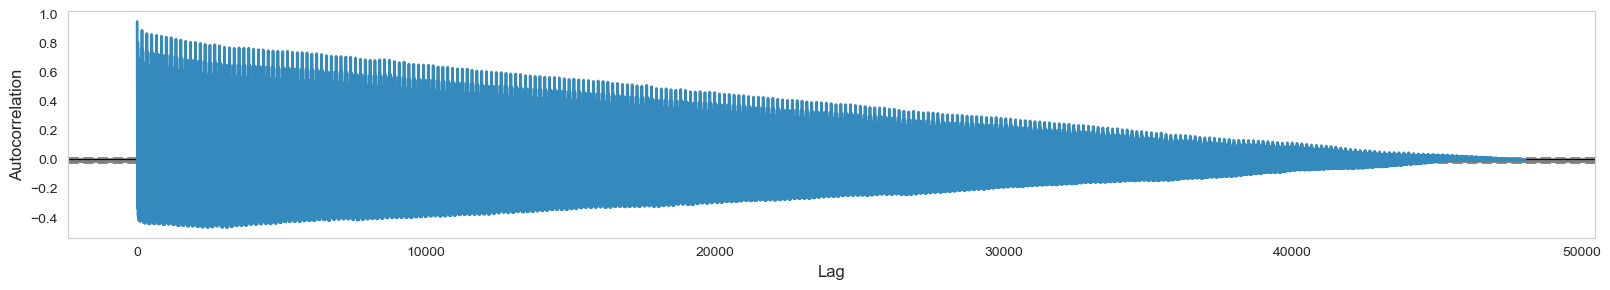

In [13]:
autocorr_analysis(data_df)

#### Analysis of seasonality

In [14]:
def seasonality_analysis(data_for_eda, period=365):
    seasonality = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period).seasonal
    fig, ax = plt.subplots(figsize = (20,5))
    ax.plot(seasonality)          

In [15]:
def decomposition(data_for_eda):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,5
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='additive')
    
    decomposition.plot()
    plt.suptitle("Decomposition", fontsize=18)

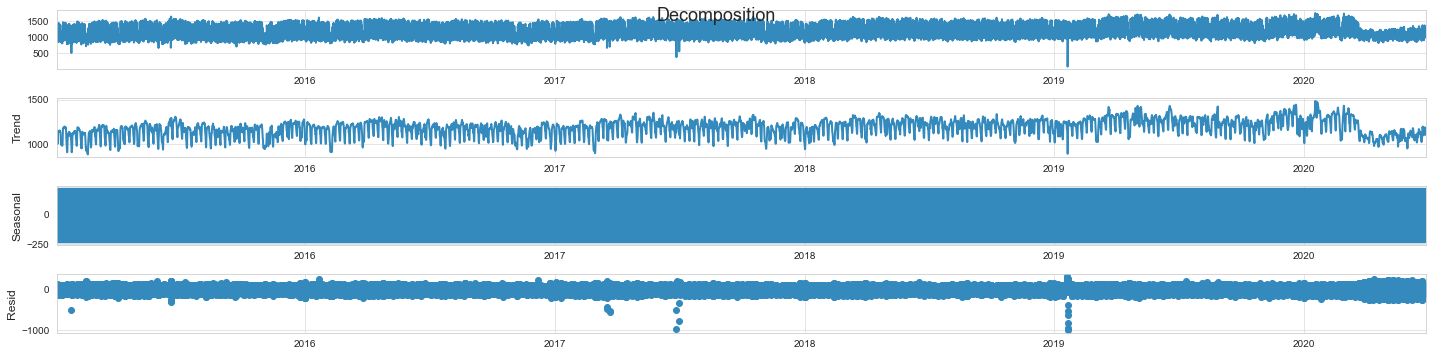

In [16]:
decomposition(data_df)

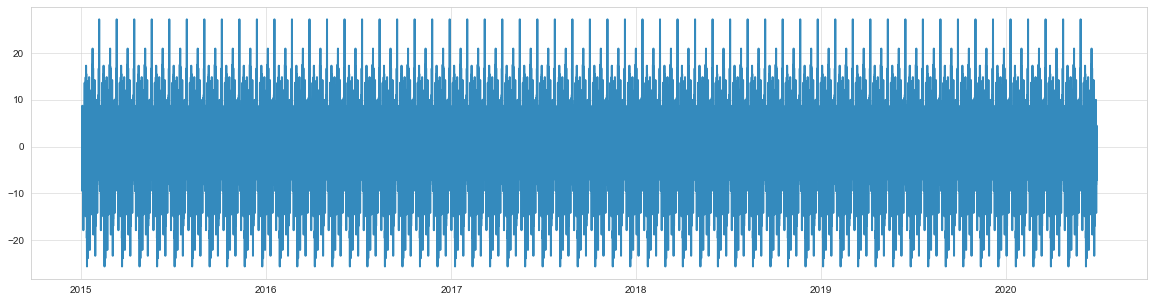

In [17]:
seasonality_analysis(data_df, period=830)

#### Analysis of stationarity

In [18]:
def stationarity_analysis(data_for_eda):
    test = sm.tsa.adfuller(data_for_eda)
    print ('adf:', test[0])
    print ('p-value:', test[1])
    print ('Critical values:', test[4])
    if test[0]> test[4]['5%']: 
        print ('\n There are single roots, the row is not stationary')
    else:
        print ('\n There are no single roots, the row is STATIONARY')

In [19]:
stationarity_analysis(data_df)

adf: -20.96175000729649
p-value: 0.0
Critical values: {'1%': -3.430486271094305, '5%': -2.861600228969454, '10%': -2.5668020578981667}

 There are no single roots, the row is STATIONARY


### DATA PREPARATION

Transform the data into a time series problem

In [20]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
data_df_resample = data_df.resample('h').mean()
data_df_resample.shape

(48048, 1)

In [22]:
values = data_df_resample.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data_df_norm = series_to_supervised(scaled, n_in=7, n_out=1, dropnan=True)
data_df_norm.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.530130,0.495291,0.488160,0.481983,0.484218,0.475561,0.507457,0.577221
8,0.495291,0.488160,0.481983,0.484218,0.475561,0.507457,0.577221,0.648453
9,0.488160,0.481983,0.484218,0.475561,0.507457,0.577221,0.648453,0.702115
10,0.481983,0.484218,0.475561,0.507457,0.577221,0.648453,0.702115,0.700364
11,0.484218,0.475561,0.507457,0.577221,0.648453,0.702115,0.700364,0.677795


In [23]:
values = data_df_norm.values

n_train_time = 365*24

train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8760, 1, 7), (39281, 1, 7), (8760,), (39281,))

### 1D CNN MODEL 

In [24]:
inputs = Input(shape=(1, 7))

x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)

x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1)(x)

model_CNN = Model(inputs, outputs, name="1D_CNN")

2021-11-10 01:55:18.294906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 01:55:18.304186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 01:55:18.304856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 01:55:18.305899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [25]:
# Compile model
model_CNN.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])

Model: "1D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             1408      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0    

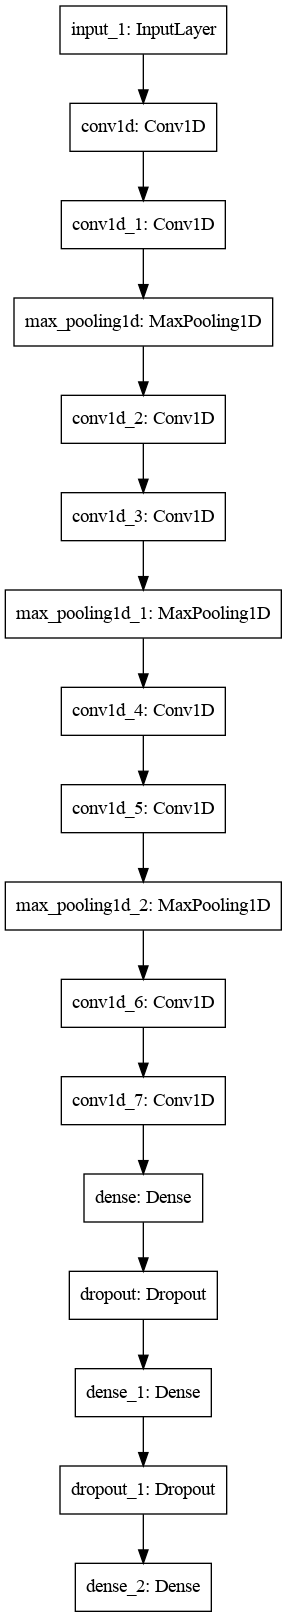

In [26]:
model_CNN.summary()
tf.keras.utils.plot_model(model_CNN, to_file='1D_CNN_model.png')

In [27]:
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_CNN.h5",
                                                   save_best_only=True)

model_CNN_history = model_CNN.fit(X_train,
                                  y_train,
                                  batch_size=64,
                                  validation_split=0.15,
                                  epochs=500,
                                  callbacks=[early_stopping_cb,
                                            checkpoint_cb])


2021-11-10 01:55:19.488037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2021-11-10 01:55:21.605730: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
2021-11-10 01:55:22.326128: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


117/117 [==============================] - 6s 22ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.0973 - val_mae: 0.0973
Epoch 2/500
117/117 [==============================] - 2s 17ms/step - loss: 0.0751 - mae: 0.0751 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 3/500
117/117 [==============================] - 2s 17ms/step - loss: 0.0404 - mae: 0.0404 - val_loss: 0.0289 - val_mae: 0.0289
Epoch 4/500
117/117 [==============================] - 2s 16ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0288 - val_mae: 0.0288
Epoch 5/500
117/117 [==============================] - 2s 16ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 6/500
117/117 [==============================] - 2s 18ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0237 - val_mae: 0.0237
Epoch 7/500
117/117 [==============================] - 2s 16ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 8/500
117/117 [==============================] - 2s 16ms/step - loss

#### EVALUATION RESULT

In [28]:
# EVALUATION AND VISUALIZATION OF MODEL PARAMETERS
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['mae'], label="Training mae")
    axR.plot(history.history['val_mae'], label="Validation mae")
    axR.set_title('Training and Validation mae')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('MAE')
    axR.legend(loc='upper right')

    plt.show()
    
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("People")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)


def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

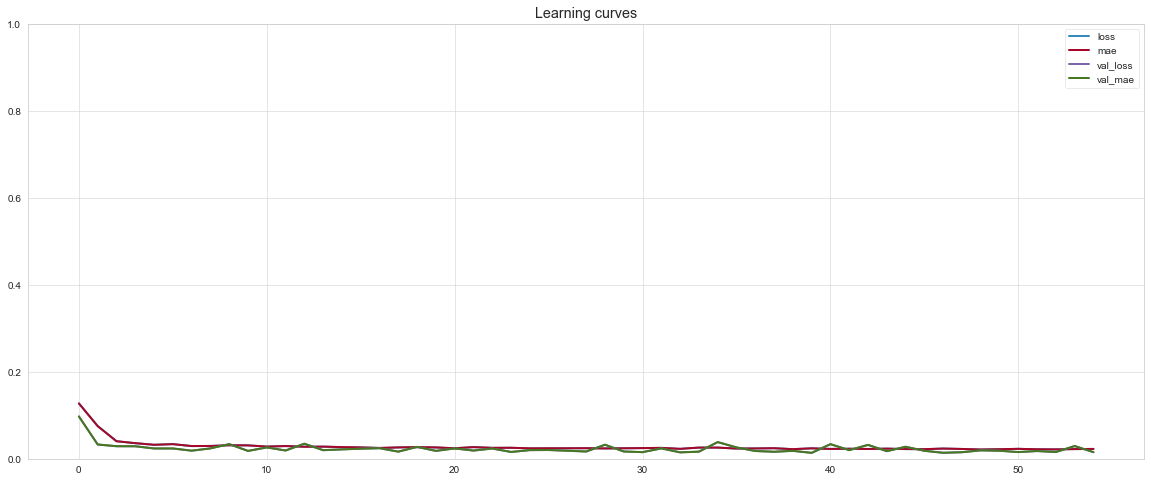

In [29]:
# Learning curves
learning_curves(model_CNN_history)

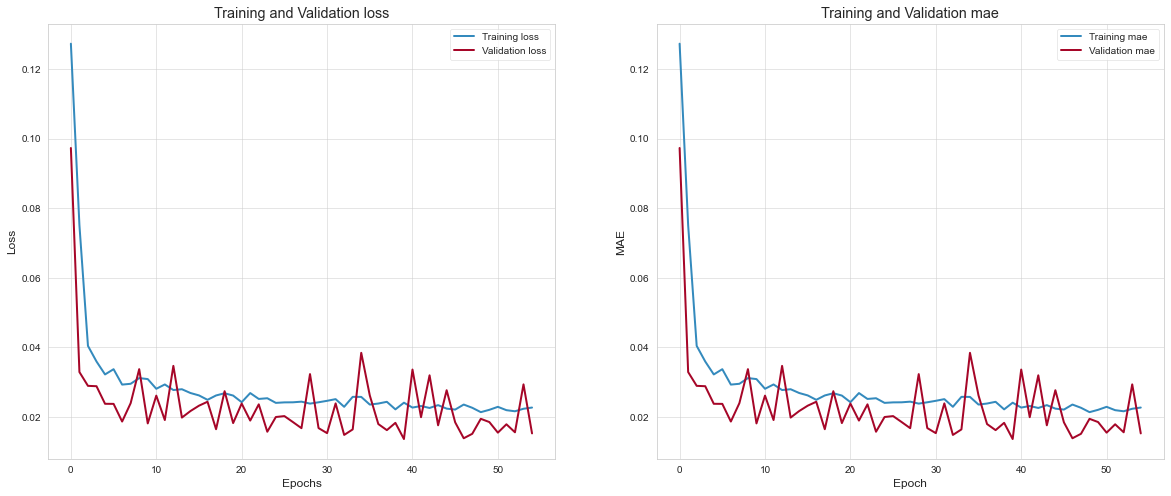

In [30]:
# Evaluation model
evaluation_model(model_CNN_history)

In [31]:
# Evaluate model on test data
model_CNN.evaluate(X_test, y_test)

1228/1228 [==============================] - 11s 8ms/step - loss: 0.0153 - mae: 0.0153


[0.015286223031580448, 0.015286223031580448]

In [32]:
# Load in saved best performing model_1 and evaluate on test data
model_CNN = tf.keras.models.load_model("model_CNN.h5")
model_CNN.evaluate(X_test, y_test)

1228/1228 [==============================] - 11s 8ms/step - loss: 0.0153 - mae: 0.0153


[0.015286223031580448, 0.015286223031580448]

In [33]:
# Make predictions
model_CNN_preds = make_preds(model_CNN, X_test)
model_CNN_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.4770658 , 0.5539335 , 0.6064053 , 0.6232724 , 0.6062986 ,
       0.60834014, 0.61199284, 0.6015705 , 0.59564936, 0.5852797 ],
      dtype=float32)>

In [34]:
# Evaluate predictions
model_CNN_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                   y_pred=model_CNN_preds)
model_CNN_results

{'mae': 0.01528622,
 'mse': 0.0004835566,
 'rmse': 0.02198992,
 'mape': 10756.049,
 'mase': 0.5647307}

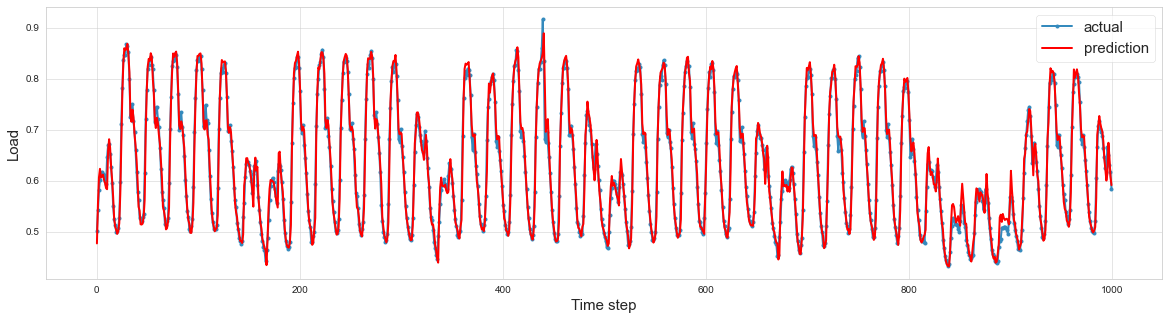

In [35]:
aa=[x for x in range(1000)]
plt.plot(aa, y_test[:1000], marker='.', label="actual")
plt.plot(aa, model_CNN_preds[:1000], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### "Quick" LSTM model for comparison

In [36]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])


In [37]:
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_LSTM.h5",
                                                   save_best_only=True)

model_LSTM_history = model.fit(X_train,
                               y_train,
                               batch_size=64,
                               validation_split=0.15,
                               epochs=500,
                               callbacks=[early_stopping_cb,
                                          checkpoint_cb])

Epoch 1/500
117/117 [==============================] - 5s 17ms/step - loss: 0.1607 - mae: 0.1607 - val_loss: 0.0612 - val_mae: 0.0612
Epoch 2/500
117/117 [==============================] - 1s 10ms/step - loss: 0.0672 - mae: 0.0672 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 3/500
117/117 [==============================] - 1s 9ms/step - loss: 0.0556 - mae: 0.0556 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 4/500
117/117 [==============================] - 1s 10ms/step - loss: 0.0523 - mae: 0.0523 - val_loss: 0.0289 - val_mae: 0.0289
Epoch 5/500
117/117 [==============================] - 1s 10ms/step - loss: 0.0493 - mae: 0.0493 - val_loss: 0.0277 - val_mae: 0.0277
Epoch 6/500
117/117 [==============================] - 1s 10ms/step - loss: 0.0470 - mae: 0.0470 - val_loss: 0.0283 - val_mae: 0.0283
Epoch 7/500
117/117 [==============================] - 1s 9ms/step - loss: 0.0458 - mae: 0.0458 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 8/500
117/117 [==============================] - 1s 10ms/s

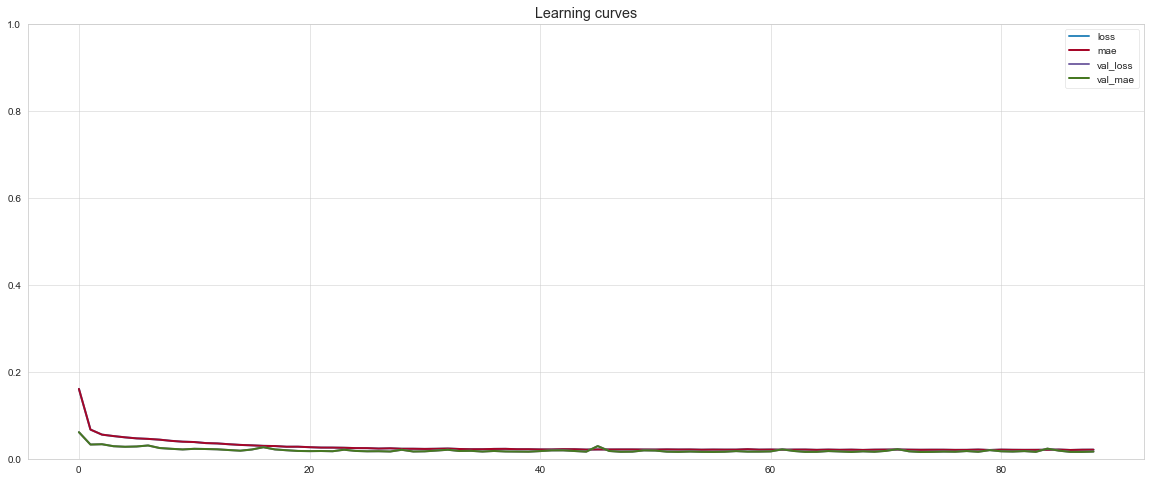

In [38]:
# Learning curves
learning_curves(model_LSTM_history)

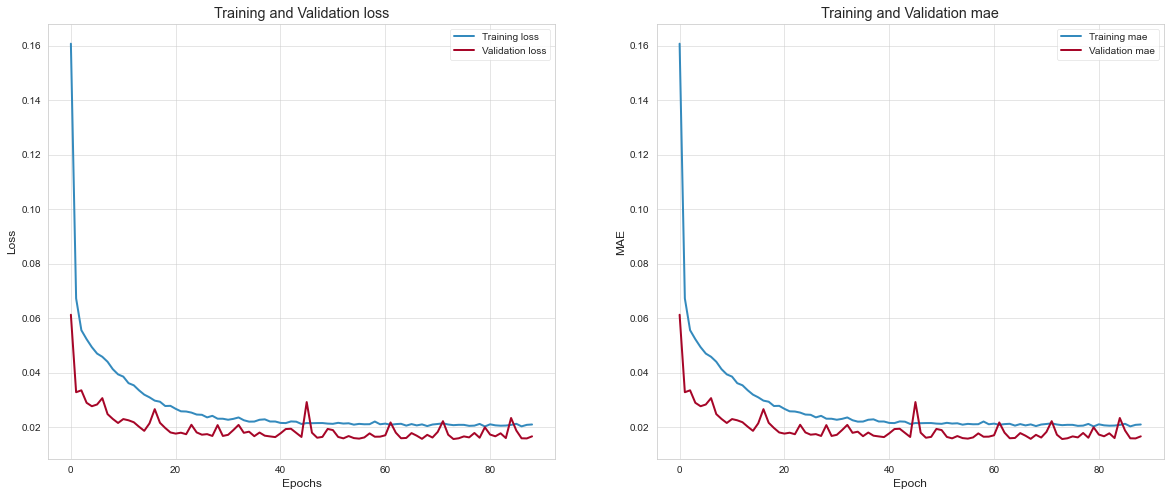

In [39]:
# Evaluation model
evaluation_model(model_LSTM_history)

In [40]:
# Evaluate model on test data
model.evaluate(X_test, y_test)

1228/1228 [==============================] - 5s 4ms/step - loss: 0.0169 - mae: 0.0169


[0.01687885820865631, 0.01687885820865631]

In [41]:
# Load in saved best performing model_1 and evaluate on test data
model = tf.keras.models.load_model("model_LSTM.h5")
model.evaluate(X_test, y_test)

1228/1228 [==============================] - 7s 5ms/step - loss: 0.0169 - mae: 0.0169


[0.01687885820865631, 0.01687885820865631]

In [42]:
# Make predictions
model_LSTM_preds = make_preds(model, X_test)
model_LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.4814664 , 0.52621615, 0.576737  , 0.6126531 , 0.6185683 ,
       0.62230736, 0.6231017 , 0.612043  , 0.6090959 , 0.59162706],
      dtype=float32)>

In [43]:
# Evaluate predictions
model_LSTM_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                    y_pred=model_LSTM_preds)
model_LSTM_results

{'mae': 0.01687886,
 'mse': 0.00067316263,
 'rmse': 0.025945377,
 'mape': 6639.41,
 'mase': 0.62356883}

In [44]:
model_CNN_results

{'mae': 0.01528622,
 'mse': 0.0004835566,
 'rmse': 0.02198992,
 'mape': 10756.049,
 'mase': 0.5647307}

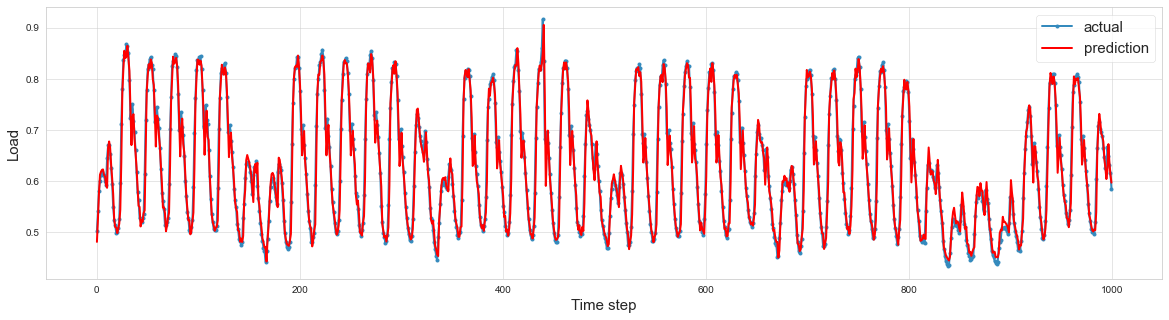

In [45]:
aa=[x for x in range(1000)]
plt.plot(aa, y_test[:1000], marker='.', label="actual")
plt.plot(aa, model_LSTM_preds[:1000], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()